# Transfer Learning with TensorFlow - Fine-Tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: Fine-tuning

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).

In [1]:
!python -m wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


Saved under helper_functions.py


In [20]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir
%matplotlib inline

> 🔑 **Note:** If you're running this notebook in Google Colab, when time out Colab will delete `helper_functions.py`, so you'll have to redownload it if you want to access your helper functions

## Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food).

In [4]:
# Get 10% of training data of 10 classes of Food 101
!python -m wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data('10_food_classes_10_percent.zip')


Saved under 10_food_classes_10_percent.zip


In [5]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [6]:
# Create training and test directory paths
train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

In [8]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.utils.image_dataset_from_directory(directory = train_dir, 
                                                                   image_size = IMG_SIZE,
                                                                   label_mode = 'categorical',
                                                                   batch_size = BATCH_SIZE)

test_data = tf.keras.utils.image_dataset_from_directory(directory = test_dir,
                                                       image_size = IMG_SIZE,
                                                       label_mode = 'categorical',
                                                       batch_size = BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [10]:
# Check out class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[ 65.7602     55.7602     28.760204 ]
   [ 85.28571    78.28571    50.285717 ]
   [ 81.91327    74.91327    48.91327  ]
   ...
   [ 99.90284    90.33137    80.1171   ]
   [ 93.760086   83.760086   73.760086 ]
   [120.47522   110.47522   100.47522  ]]

  [[ 91.301025   81.301025   56.301025 ]
   [ 60.056118   52.19387    28.78061  ]
   [ 67.92346    59.923466   36.923466 ]
   ...
   [105.75566    96.18419    85.969925 ]
   [119.63736   109.63736    99.63736  ]
   [ 70.1075     60.1075     50.1075   ]]

  [[ 72.36735    61.36735    39.79592  ]
   [ 74.2398     66.2398     45.66837  ]
   [ 92.65816    84.65816    64.08673  ]
   ...
   [ 80.41272    70.84125    58.62698  ]
   [109.6483     99.6483     87.6483   ]
   [129.87741   119.8774    107.8774   ]]

  ...

  [[114.50039    80.50039    68.653435 ]
   [105.52099    72.505684   56.09237  ]
   [117.09771    84.883446   64.31197  ]
   ...
   [ 32.714417    7.1429443   6.3572083]
   [ 38.229633   13.443896    9.872424 ]
   [ 

## Model 0:  Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our model

In [13]:
# 1. Create base model with tf.keras.Applications
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated)
base_model.trainable = False

# 3. Create input into our model
inputs = tf.keras.layers.Input(shape =(224,224,3), name='input_layer')

# 4. If using model like ResNet50V2 you will need to normalize inputs (you dont' have to for effnet)
#x = tf.keras.layers.Rescaling(1/255.)(inputs)

# 5. Pass the inputs 
x = base_model(inputs)
print(f'Shape after passing through base model {x.shape}')

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x)
print(f'Shape after GlobalAveragePooling2D:{x.shape}')

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation ='softmax', name='output_layer')(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. compile the model
model_0.compile(loss = 'categorical_crossentropy',
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])

# 10. Fit the model and save its history
history_0 = model_0.fit(train_data_10_percent,
                       epochs = 5,
                       steps_per_epoch = len(train_data_10_percent),
                       validation_data = test_data,
                       validation_steps = int(0.25 * len(test_data)),
                       callbacks = [create_tensorboard_callback(dir_name ='transfer_learning',
                                                                experiment_name='10_percent_feature_extraction')])

Shape after passing through base model (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D:(None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20210914-082714
Epoch 1/5


D:\Anaconda3\envs\TensorflowTut\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


24/24 [==============================] - 19s 425ms/step - loss: 1.9303 - accuracy: 0.4147 - val_loss: 1.3511 - val_accuracy: 0.7056
Epoch 2/5
24/24 [==============================] - 7s 299ms/step - loss: 1.1632 - accuracy: 0.7400 - val_loss: 0.9157 - val_accuracy: 0.8010
Epoch 3/5
24/24 [==============================] - 7s 296ms/step - loss: 0.8494 - accuracy: 0.7960 - val_loss: 0.7645 - val_accuracy: 0.8109
Epoch 4/5
24/24 [==============================] - 7s 300ms/step - loss: 0.6895 - accuracy: 0.8280 - val_loss: 0.6513 - val_accuracy: 0.8388
Epoch 5/5
24/24 [==============================] - 7s 299ms/step - loss: 0.6004 - accuracy: 0.8547 - val_loss: 0.5994 - val_accuracy: 0.8470


In [14]:
# Evaluate on the full test datset
model_0.evaluate(test_data)

79/79 [==============================] - 13s 165ms/step - loss: 0.6072 - accuracy: 0.8472


[0.6072419285774231, 0.8471999764442444]

In [15]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_2
1 rescaling_1
2 normalization_1
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_d

In [16]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, None, None, 3 7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_1[0][0]            
_____________________________________________________________________________________

In [17]:
# How about a summary of our whole model?
model_0.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


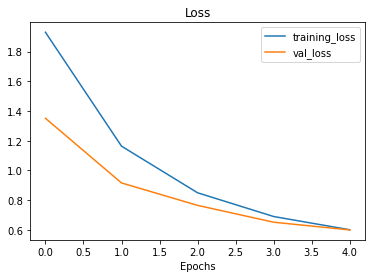

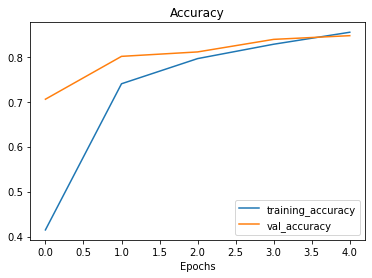

In [21]:
# Check out our model's loss curves
plot_loss_curves(history_0)